In [1]:
# importing the libraries

import numpy as np
from datetime import datetime

import torch
import torch.nn.utils as torch_utils
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import display, Image
from torchviz import make_dot, make_dot_from_trace
from torchsummary import summary

In [2]:
# getting the cpu cores

import os

os.cpu_count()

16

In [3]:
# setting up the model parameters
rand_seed = 42
lr_rate = 0.001
batch_size = 32
epochs = 15

img_sz = 32
classes = 10

In [4]:
# check for gpu if available
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
dev

'cuda'

In [6]:
# getting and prep the data 

# data augmentation
image_transformer = transforms.Compose([
                transforms.Resize((20, 20)), # resize the images to 32x32
                transforms.ToTensor() # convert the images to tensors
])

# training data 
train_dataset = datasets.MNIST(root='mnist_data', 
                                train=True,
                                transform=image_transformer,
                                download=True
                              )

# validation dataset
valid_dataset = datasets.MNIST(root='mnist_data',
                                train=False,
                                transform=image_transformer)

# Data loaders
train_dloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

Text(0.5, 0.98, 'MNIST Preview')

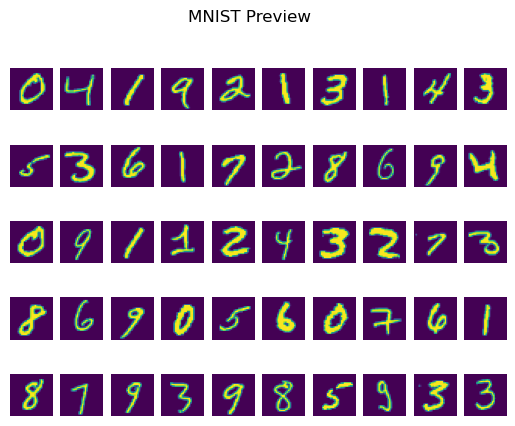

In [7]:
# image visualization
fg = plt.figure()
# image row = 10
# each rows = 5
for indx in range(1, 10*5+1):
    plt.subplot(5, 10, indx)
    plt.axis('off')
    plt.imshow(train_dataset.data[indx])
fg.suptitle("MNIST Preview")

Text(0.5, 0.98, 'MNIST GrayScale Preview')

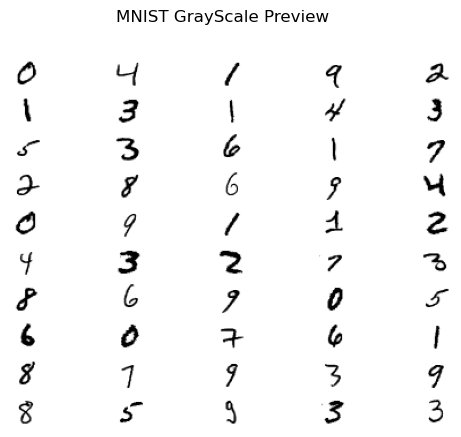

In [8]:
# checking in grayscale
fg = plt.figure()
for indx in range(1, 10*5+1):
    plt.subplot(10, 5, indx)
    plt.axis('off')
    plt.imshow(train_dataset.data[indx], cmap='gray_r')
fg.suptitle('MNIST GrayScale Preview')

In [9]:
def get_acc(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    total_pred = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            
            logits = model(X)
            _, predicted_labels = torch.max(logits, 1)
            
            correct_pred += (predicted_labels == y_true).sum().item()
            total_pred += len(y_true)  # Instead of y_true.size(0)

    accuracy = correct_pred / total_pred * 100
    return accuracy


def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

# training engine
def train(train_dloader, model, criterion, optimizer, device):
    '''
        Training Engine
    '''
    model.train()
    curr_loss = 0
    correct_pred = 0 
    total_pred = 0
    
    for x, y_true in train_dloader:
        # backpropagate so setting the grads to zero
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch#48009142
        optimizer.zero_grad()
        
        # set the model to the selected device
        x = x.to(device)
        y_true = y_true.to(device)
        
        # forward prop
        logits = model(x)  # Only use logits
        loss = criterion(logits, y_true)
        curr_loss += loss.item() * x.size(0)
        
        # calculate accuracy within the training loop
        _, predicted_labels = torch.max(logits, 1)
        correct_pred += (predicted_labels == y_true).sum().item()
        total_pred += len(y_true)
        
        # backprop
        loss.backward()
        optimizer.step()
        
    epoch_loss = curr_loss / len(train_dloader.dataset)
    accuracy = correct_pred / total_pred * 100
    return model, optimizer, epoch_loss, accuracy

# validation engine
def validate(valid_dloader, model, criterion, device):
    '''
        Validation Engine
    '''
    model.eval()
    curr_loss = 0
    
    for x, y_true in valid_dloader:
        x = x.to(device)
        y_true = y_true.to(device)
        
        # forward prop
        logits = model(x)  # Only use logits
        loss = criterion(logits, y_true)
        curr_loss += loss.item() * x.size(0)
        
    epoch_loss = curr_loss / len(valid_dloader.dataset)
    return model, epoch_loss


# creating a training loop engine
def train_engine(model, criterion, optimizer, train_dloader, 
                 valid_dloader, epochs, device, verbose=1):
    '''
        Training Loop Engine defined for the models
    '''
    
    # baseline training metrics
    loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracies = []  # Track train accuracies
    valid_accuracies = []  # Track validation accuracies
    
    for epoch in range(0, epochs):
        # training 
        model, optimizer, train_loss, train_accuracy = train(train_dloader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)  # Append the train accuracy
        
        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_dloader, model, criterion, device)
            valid_losses.append(valid_loss)
            valid_accuracy = get_acc(model, valid_dloader, device=device)  # Calculate validation accuracy
            valid_accuracies.append(valid_accuracy)  # Append the validation accuracy
            
        if epoch % verbose == (verbose - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {train_accuracy:.2f}\t'
                  f'Valid accuracy: {valid_accuracy:.2f}')
            
    plot_losses(train_losses, valid_losses)
    return model, optimizer, (train_losses, valid_losses, train_accuracies, valid_accuracies)

# BaseLine Classifier

In [10]:
# Baseline Classifier

class LinearClassifier(nn.Module):
    def __init__(self, input_size, classes):
        super(LinearClassifier, self).__init__()

        # Define the fully connected layer
        # 20 * 20 --> 400 mapped to 10
        self.fc = nn.Linear(input_size, classes)
    
    def forward(self, x):
        # Flatten the input tensor to a 1D tensor
        x = torch.flatten(x, 1)
        
        # Pass the flattened input through the fully connected layer
        logits = self.fc(x)
        
        # Return the output logits
        return logits

In [11]:
torch.manual_seed(rand_seed)
input_size = 20*20
model = LinearClassifier(input_size, classes).to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

00:11:11 --- Epoch: 0	Train loss: 0.5869	Valid loss: 0.3482	Train accuracy: 86.27	Valid accuracy: 90.94
00:11:19 --- Epoch: 1	Train loss: 0.3382	Valid loss: 0.3019	Train accuracy: 90.66	Valid accuracy: 91.71
00:11:28 --- Epoch: 2	Train loss: 0.3067	Valid loss: 0.2868	Train accuracy: 91.48	Valid accuracy: 91.76
00:11:37 --- Epoch: 3	Train loss: 0.2923	Valid loss: 0.2769	Train accuracy: 91.82	Valid accuracy: 92.14
00:11:46 --- Epoch: 4	Train loss: 0.2836	Valid loss: 0.2732	Train accuracy: 92.03	Valid accuracy: 92.26
00:11:55 --- Epoch: 5	Train loss: 0.2781	Valid loss: 0.2688	Train accuracy: 92.16	Valid accuracy: 92.51
00:12:04 --- Epoch: 6	Train loss: 0.2740	Valid loss: 0.2668	Train accuracy: 92.31	Valid accuracy: 92.61
00:12:13 --- Epoch: 7	Train loss: 0.2707	Valid loss: 0.2651	Train accuracy: 92.35	Valid accuracy: 92.60
00:12:22 --- Epoch: 8	Train loss: 0.2680	Valid loss: 0.2634	Train accuracy: 92.48	Valid accuracy: 92.68
00:12:30 --- Epoch: 9	Train loss: 0.2659	Valid loss: 0.2616	Trai

/tmp/ipykernel_29155/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_29155/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


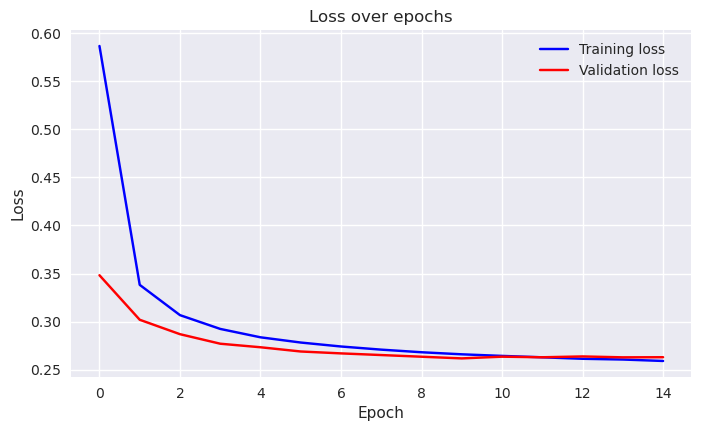

In [12]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader, valid_dloader, epochs, dev)

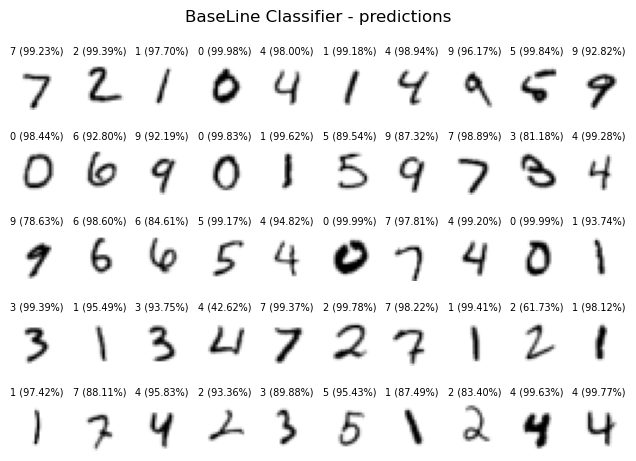

In [13]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
# the minimum of the total number of images in the valid_dataset and the product of ROW_IMG and N_ROWS, ensuring that the plot won't exceed the available data.
num_subplots = min(len(valid_dataset), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    """
     loop iterates through the num_subplots and creates a subplot at the current index. It turns off the axis for each subplot, making the plot cleaner without any axis ticks.
    """
    img = valid_dataset[index][0].unsqueeze(0).to(dev)
    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    """
    It fetches the image tensor from the valid_dataset at the current index and converts it to a 4-dimensional tensor with a batch size of 1 (unsqueeze). 
    The image tensor is then moved to the device dev (presumably GPU) for faster processing. 
    Finally, the image is displayed using imshow, and the gray_r colormap is used to display the image in grayscale.
    """
    with torch.no_grad():
        model.eval()
        probs = model(img)
    # The model is put into evaluation mode (model.eval()) and a forward pass is made with the image tensor img. 
    # The output probs will contain the probability distribution of the model's predictions.
    label = valid_dataset[index][1]  # Access the label directly
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100  # Calculate max probability
    title = f'{label} ({probability:.2f}%)'

    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('BaseLine Classifier - predictions')
plt.show()

In [14]:
# Instantiate your model with the appropriate input_size and classes
input_size = 20 * 20
classes = 10
model = LinearClassifier(input_size, classes)

# Move the model to the GPU
model = model.to(dev)

# Provide dummy input
dummy_input = torch.randn(1, input_size).to(dev)

# Create the graph and save it as an image
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('linear_classifier_graph', directory='./', view=False)

'linear_classifier_graph.png'

#  One-Hidden-Layer Fully Connected Multilayer Neural Network

In [15]:
class OneHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size, classes):
        super(OneHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, classes)
        
    def forward(self, x):
        # Flatten the input tensor along the second dimension to convert images into a 1D vector
        x = torch.flatten(x, 1)

        # Pass the flattened input through the first hidden layer, applying the ReLU activation function
        x = torch.relu(self.fc1(x))

        # Compute the logits (raw predictions) for each class using the second fully connected layer
        logits = self.fc2(x)

        # Return the logits, which can be further processed to obtain probabilities using a softmax function
        return logits

In [16]:
torch.manual_seed(rand_seed)
input_size = 20*20
hidden_size = 300
model = OneHiddenLayer(input_size, hidden_size, classes).to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

00:13:25 --- Epoch: 0	Train loss: 0.2851	Valid loss: 0.1408	Train accuracy: 91.98	Valid accuracy: 95.92
00:13:34 --- Epoch: 1	Train loss: 0.1225	Valid loss: 0.1043	Train accuracy: 96.35	Valid accuracy: 97.04
00:13:44 --- Epoch: 2	Train loss: 0.0864	Valid loss: 0.0892	Train accuracy: 97.33	Valid accuracy: 97.28
00:13:53 --- Epoch: 3	Train loss: 0.0670	Valid loss: 0.0705	Train accuracy: 97.95	Valid accuracy: 97.73
00:14:03 --- Epoch: 4	Train loss: 0.0539	Valid loss: 0.0701	Train accuracy: 98.34	Valid accuracy: 97.95
00:14:12 --- Epoch: 5	Train loss: 0.0437	Valid loss: 0.0712	Train accuracy: 98.64	Valid accuracy: 97.77
00:14:22 --- Epoch: 6	Train loss: 0.0359	Valid loss: 0.0641	Train accuracy: 98.90	Valid accuracy: 98.07
00:14:31 --- Epoch: 7	Train loss: 0.0312	Valid loss: 0.0630	Train accuracy: 99.03	Valid accuracy: 98.09
00:14:40 --- Epoch: 8	Train loss: 0.0247	Valid loss: 0.0604	Train accuracy: 99.27	Valid accuracy: 98.20
00:14:49 --- Epoch: 9	Train loss: 0.0215	Valid loss: 0.0712	Trai

/tmp/ipykernel_29155/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_29155/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


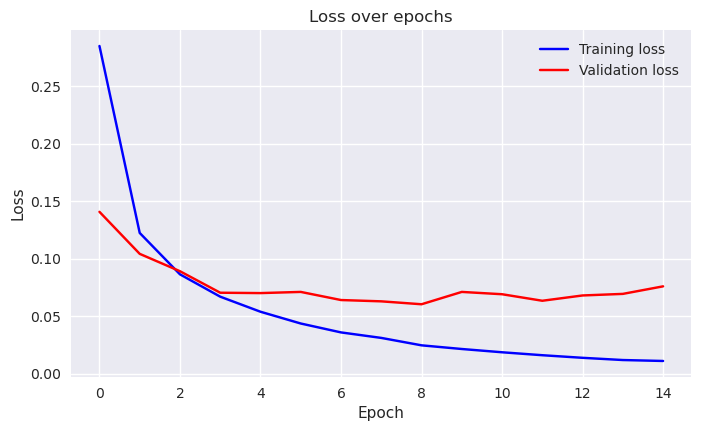

In [17]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader, valid_dloader, epochs, dev)

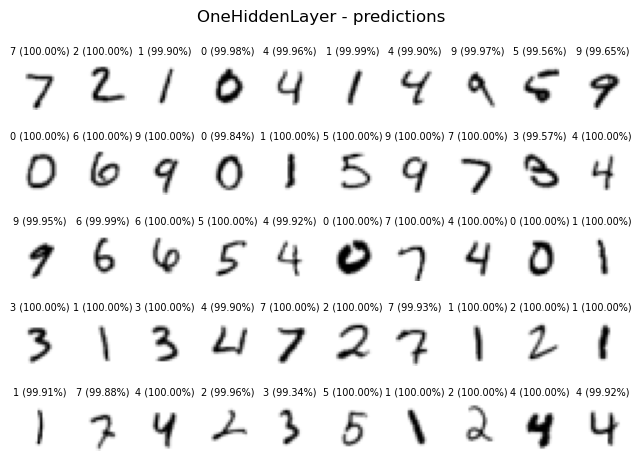

In [18]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
# the minimum of the total number of images in the valid_dataset and the product of ROW_IMG and N_ROWS, ensuring that the plot won't exceed the available data.
num_subplots = min(len(valid_dataset), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    """
     loop iterates through the num_subplots and creates a subplot at the current index. It turns off the axis for each subplot, making the plot cleaner without any axis ticks.
    """
    img = valid_dataset[index][0].unsqueeze(0).to(dev)
    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    """
    It fetches the image tensor from the valid_dataset at the current index and converts it to a 4-dimensional tensor with a batch size of 1 (unsqueeze). 
    The image tensor is then moved to the device dev (presumably GPU) for faster processing. 
    Finally, the image is displayed using imshow, and the gray_r colormap is used to display the image in grayscale.
    """
    with torch.no_grad():
        model.eval()
        probs = model(img)
    # The model is put into evaluation mode (model.eval()) and a forward pass is made with the image tensor img. 
    # The output probs will contain the probability distribution of the model's predictions.
    label = valid_dataset[index][1]  # Access the label directly
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100  # Calculate max probability
    title = f'{label} ({probability:.2f}%)'

    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('OneHiddenLayer - predictions')
plt.show()

In [19]:
# Instantiate your model with the appropriate input_size, hidden_size, and classes
input_size = 20 * 20
hidden_size = 300
classes = 10
model = OneHiddenLayer(input_size, hidden_size, classes)

# Move the model to the GPU
model = model.to(dev)

# Provide dummy input
dummy_input = torch.randn(1, input_size).to(dev)

# Create the graph and save it as an image
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('one_hidden_layer_graph', directory='./', view=False)

'one_hidden_layer_graph.png'

# Two Hidden Layer Fully Connected Multilayer Neural Network

In [20]:
# Tranform and form the resize the image to 28 * 28 

# getting and prep the data 

# data augmentation
image_transformer_two_hd_layer = transforms.Compose([
                transforms.Resize((28, 28)), # resize the images to 32x32
                transforms.ToTensor() # convert the images to tensors
])

# training data 
train_dataset_two_hd_layer = datasets.MNIST(root='mnist_data_two_hidden_layer', 
                                train=True,
                                transform=image_transformer_two_hd_layer,
                                download=True
                              )

# validation dataset
valid_dataset_two_hd_layer = datasets.MNIST(root='mnist_data_two_hidden_layer',
                                train=False,
                                transform=image_transformer_two_hd_layer)

# Data loaders
train_dloader_two_hd_layer = DataLoader(dataset=train_dataset_two_hd_layer, batch_size=batch_size, shuffle=True)
valid_dloader_two_hd_layer = DataLoader(dataset=valid_dataset_two_hd_layer, batch_size=batch_size, shuffle=True)

Text(0.5, 0.98, 'MNIST GrayScale Preview After 28*28')

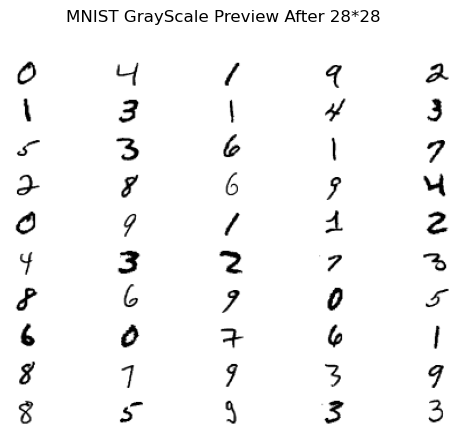

In [21]:
# checking in grayscale
fg = plt.figure()
for indx in range(1, 10*5+1):
    plt.subplot(10, 5, indx)
    plt.axis('off')
    plt.imshow(train_dataset.data[indx], cmap='gray_r')
fg.suptitle('MNIST GrayScale Preview After 28*28')

In [22]:
# Two Hidden Layer Fully Connected 
class TwoHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, classes):
        super(TwoHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, classes)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [23]:
torch.manual_seed(rand_seed)
input_size = 28*28
hidden_size1 = 300
hidden_size2 = 100
model = TwoHiddenLayer(input_size, hidden_size1, hidden_size2,classes).to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

00:15:48 --- Epoch: 0	Train loss: 0.2424	Valid loss: 0.1254	Train accuracy: 92.83	Valid accuracy: 95.92
00:15:57 --- Epoch: 1	Train loss: 0.0959	Valid loss: 0.0983	Train accuracy: 97.04	Valid accuracy: 96.86
00:16:06 --- Epoch: 2	Train loss: 0.0633	Valid loss: 0.0751	Train accuracy: 98.02	Valid accuracy: 97.73
00:16:15 --- Epoch: 3	Train loss: 0.0471	Valid loss: 0.0700	Train accuracy: 98.45	Valid accuracy: 97.77
00:16:24 --- Epoch: 4	Train loss: 0.0363	Valid loss: 0.0805	Train accuracy: 98.83	Valid accuracy: 97.59
00:16:33 --- Epoch: 5	Train loss: 0.0304	Valid loss: 0.0738	Train accuracy: 98.95	Valid accuracy: 97.85
00:16:42 --- Epoch: 6	Train loss: 0.0234	Valid loss: 0.0782	Train accuracy: 99.23	Valid accuracy: 97.94
00:16:51 --- Epoch: 7	Train loss: 0.0200	Valid loss: 0.0775	Train accuracy: 99.31	Valid accuracy: 98.00
00:17:01 --- Epoch: 8	Train loss: 0.0175	Valid loss: 0.1015	Train accuracy: 99.41	Valid accuracy: 97.63
00:17:10 --- Epoch: 9	Train loss: 0.0171	Valid loss: 0.0961	Trai

/tmp/ipykernel_29155/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_29155/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


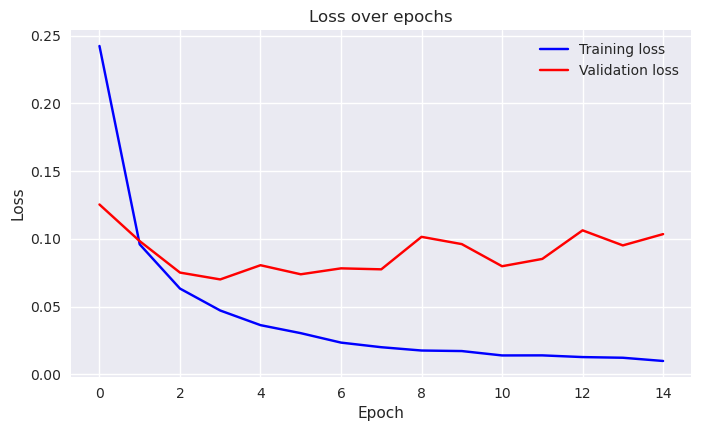

In [24]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader_two_hd_layer, valid_dloader_two_hd_layer, epochs, dev)

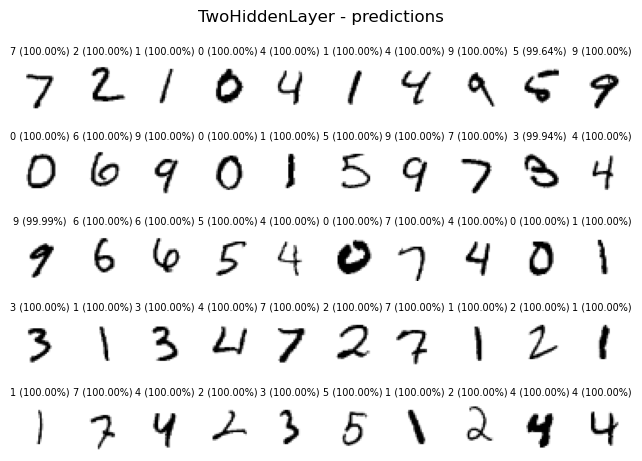

In [25]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
num_subplots = min(len(valid_dataset_two_hd_layer), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    
    # Get the image and convert it back to a PIL Image
    img, _ = valid_dataset_two_hd_layer[index]
    img_pil = transforms.ToPILImage()(img)

    # Preprocess the PIL Image using the same transformer used during training
    img = image_transformer_two_hd_layer(img_pil).unsqueeze(0).to(dev)

    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    # The rest of the visualization loop remains unchanged
    with torch.no_grad():
        model.eval()
        probs = model(img)
    label = valid_dataset_two_hd_layer[index][1]
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100
    title = f'{label} ({probability:.2f}%)'
    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('TwoHiddenLayer - predictions')
plt.show()

In [26]:
# Instantiate your model with the appropriate input_size, hidden_size1, hidden_size2, and classes
input_size = 28 * 28
hidden_size1 = 300
hidden_size2 = 100
classes = 10
model = TwoHiddenLayer(input_size, hidden_size1, hidden_size2, classes)

# Move the model to the GPU
model = model.to(dev)

# Provide dummy input
dummy_input = torch.randn(1, input_size).to(dev)

# Create the graph and save it as an image
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('two_hidden_layer_graph', directory='./', view=False)

'two_hidden_layer_graph.png'

# LeNet-1

In [27]:
class LeNet1(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5)  # 28x28x1 -> 24x24x4
        self.pool1 = nn.AvgPool2d(kernel_size=2)     # 24x24x4 -> 12x12x4
        self.conv2 = nn.Conv2d(4, 12, kernel_size=5)  # 12x12x4 -> 8x8x12
        self.pool2 = nn.AvgPool2d(kernel_size=2)     # 8x8x12 -> 4x4x12
        self.conv3 = nn.Conv2d(12, 10, kernel_size=4) # 4x4x12 -> 1x1x10
        self.fc = nn.Linear(10, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layer
        x = self.fc(x)
        return x

In [28]:
torch.manual_seed(rand_seed)
model = LeNet1().to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

00:18:07 --- Epoch: 0	Train loss: 0.4230	Valid loss: 0.1869	Train accuracy: 86.59	Valid accuracy: 94.42
00:18:17 --- Epoch: 1	Train loss: 0.1601	Valid loss: 0.1235	Train accuracy: 95.28	Valid accuracy: 96.12
00:18:27 --- Epoch: 2	Train loss: 0.1144	Valid loss: 0.0866	Train accuracy: 96.57	Valid accuracy: 97.32
00:18:37 --- Epoch: 3	Train loss: 0.0926	Valid loss: 0.0717	Train accuracy: 97.15	Valid accuracy: 97.81
00:18:47 --- Epoch: 4	Train loss: 0.0794	Valid loss: 0.0630	Train accuracy: 97.60	Valid accuracy: 97.99
00:18:57 --- Epoch: 5	Train loss: 0.0699	Valid loss: 0.0613	Train accuracy: 97.88	Valid accuracy: 97.92
00:19:07 --- Epoch: 6	Train loss: 0.0633	Valid loss: 0.0608	Train accuracy: 98.03	Valid accuracy: 98.08
00:19:16 --- Epoch: 7	Train loss: 0.0571	Valid loss: 0.0569	Train accuracy: 98.20	Valid accuracy: 98.33
00:19:26 --- Epoch: 8	Train loss: 0.0520	Valid loss: 0.0532	Train accuracy: 98.43	Valid accuracy: 98.33
00:19:36 --- Epoch: 9	Train loss: 0.0488	Valid loss: 0.0453	Trai

/tmp/ipykernel_29155/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_29155/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


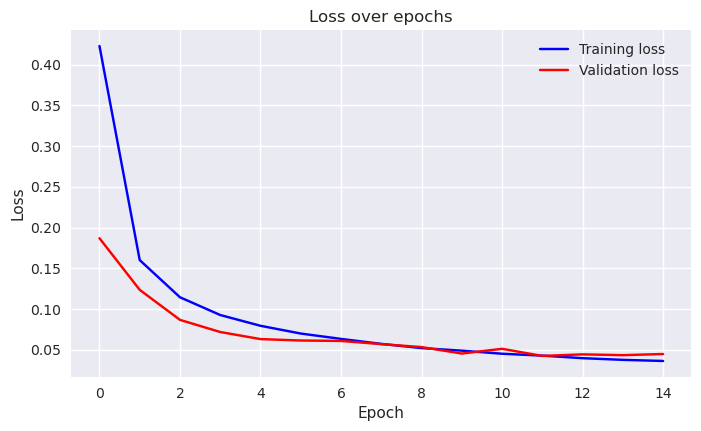

In [29]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader_two_hd_layer, valid_dloader_two_hd_layer, epochs, dev)

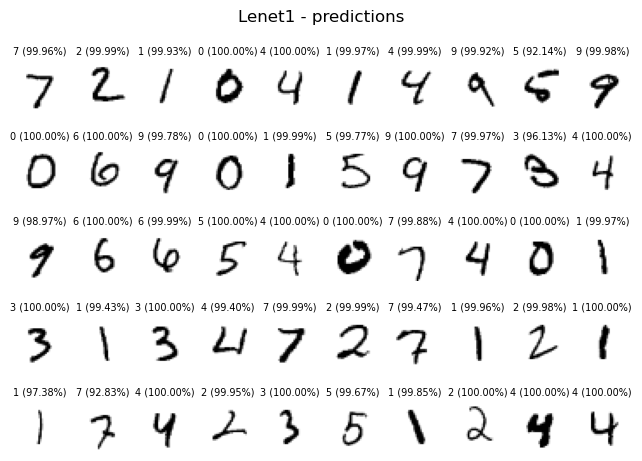

In [30]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
num_subplots = min(len(valid_dataset_two_hd_layer), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    
    # Get the image and convert it back to a PIL Image
    img, _ = valid_dataset_two_hd_layer[index]
    img_pil = transforms.ToPILImage()(img)

    # Preprocess the PIL Image using the same transformer used during training
    img = image_transformer_two_hd_layer(img_pil).unsqueeze(0).to(dev)

    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    # The rest of the visualization loop remains unchanged
    with torch.no_grad():
        model.eval()
        probs = model(img)
    label = valid_dataset_two_hd_layer[index][1]
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100
    title = f'{label} ({probability:.2f}%)'
    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Lenet1 - predictions')
plt.show()

In [31]:
# Instantiate your model with the appropriate num_classes
num_classes = 10
model = LeNet1(num_classes)

# Move the model to the GPU
model = model.to(dev)

# Provide dummy input
dummy_input = torch.randn(1, 1, 28, 28).to(dev)

# Create the graph
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Display the graph directly in the Jupyter Notebook
dot.format = 'png'
dot.render('lenet1_graph', directory='./', view=False)
dot.view()

'lenet1_graph.png'

# Lenet 4

In [32]:
# Tranform and form the resize the image to 32 * 32

# getting and prep the data 

# data augmentation
image_transformer_lenet4up = transforms.Compose([
                transforms.Resize((32, 32)), # resize the images to 32x32
                transforms.ToTensor() # convert the images to tensors
])

# training data 
train_dataset_lenet4up = datasets.MNIST(root='mnist_lenet4up', 
                                train=True,
                                transform=image_transformer_lenet4up,
                                download=True
                              )

# validation dataset
valid_dataset_lenet4up = datasets.MNIST(root='mnist_lenet4up',
                                train=False,
                                transform=image_transformer_lenet4up)

# Data loader
train_dloader_lenet4up = DataLoader(dataset=train_dataset_lenet4up, batch_size=batch_size, shuffle=True)
valid_dloader_lenet4up = DataLoader(dataset=valid_dataset_lenet4up, batch_size=batch_size, shuffle=True)

Opening in existing browser session.


Text(0.5, 0.98, 'MNIST GrayScale Preview After 32*32')

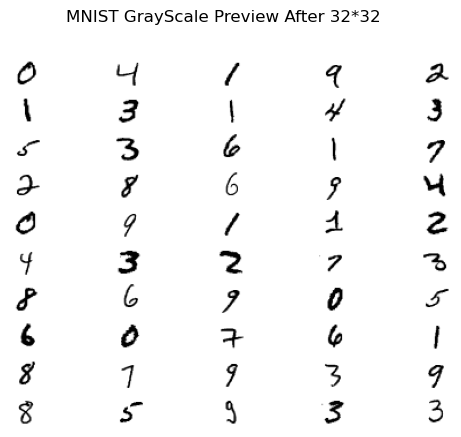

In [33]:
# checking in grayscale
fg = plt.figure()
for indx in range(1, 10*5+1):
    plt.subplot(10, 5, indx)
    plt.axis('off')
    plt.imshow(train_dataset.data[indx], cmap='gray_r')
fg.suptitle('MNIST GrayScale Preview After 32*32')

In [34]:
class LeNet4(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet4, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5)   # 32x32x1 -> 28x28x4
        self.pool1 = nn.AvgPool2d(kernel_size=2)      # 28x28x4 -> 14x14x4
        self.conv2 = nn.Conv2d(4, 16, kernel_size=5)  # 14x14x4 -> 10x10x16
        self.pool2 = nn.AvgPool2d(kernel_size=2)      # 10x10x16 -> 5x5x16
        self.fc1 = nn.Linear(16 * 5 * 5, 120)         # Flatten to 1D vector, 16x5x5 = 400
        self.fc2 = nn.Linear(120, num_classes)        # 120 -> num_classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        """
        When using the nn.AvgPool2d in the model, the spatial dimensions are reduced, and that's causing the shape mismatch in the fully connected layers.

        To fix this issue, we can use the nn.AdaptiveAvgPool2d layer instead of nn.AvgPool2d in the LeNet4 model. 
        The nn.AdaptiveAvgPool2d layer allows us to specify the output size, which will make sure the tensor dimensions match for the fully connected layers.
        """
        x = F.adaptive_avg_pool2d(x, (5, 5))          # Use adaptive_avg_pool2d
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
torch.manual_seed(rand_seed)
model = LeNet4().to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

00:20:37 --- Epoch: 0	Train loss: 0.2300	Valid loss: 0.0745	Train accuracy: 93.27	Valid accuracy: 97.59
00:20:48 --- Epoch: 1	Train loss: 0.0748	Valid loss: 0.0520	Train accuracy: 97.65	Valid accuracy: 98.40
00:20:59 --- Epoch: 2	Train loss: 0.0530	Valid loss: 0.0477	Train accuracy: 98.36	Valid accuracy: 98.46
00:21:10 --- Epoch: 3	Train loss: 0.0413	Valid loss: 0.0402	Train accuracy: 98.66	Valid accuracy: 98.84
00:21:21 --- Epoch: 4	Train loss: 0.0325	Valid loss: 0.0437	Train accuracy: 98.98	Valid accuracy: 98.55
00:21:31 --- Epoch: 5	Train loss: 0.0274	Valid loss: 0.0368	Train accuracy: 99.12	Valid accuracy: 98.88
00:21:42 --- Epoch: 6	Train loss: 0.0238	Valid loss: 0.0307	Train accuracy: 99.25	Valid accuracy: 99.01
00:21:54 --- Epoch: 7	Train loss: 0.0193	Valid loss: 0.0342	Train accuracy: 99.36	Valid accuracy: 98.90
00:22:06 --- Epoch: 8	Train loss: 0.0171	Valid loss: 0.0346	Train accuracy: 99.44	Valid accuracy: 99.02
00:22:17 --- Epoch: 9	Train loss: 0.0139	Valid loss: 0.0349	Trai

/tmp/ipykernel_29155/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_29155/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


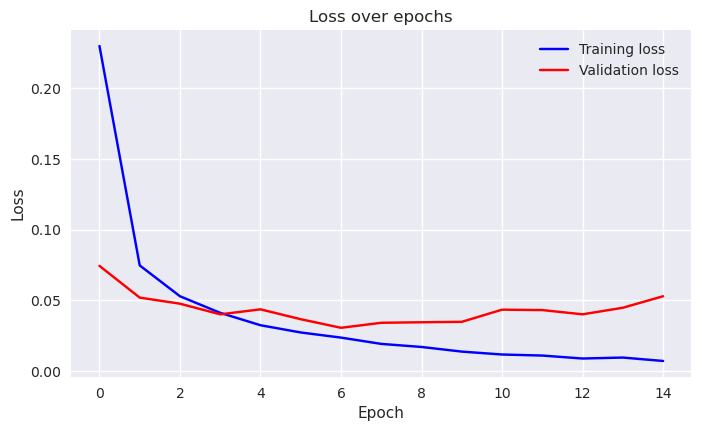

In [36]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader_lenet4up, valid_dloader_lenet4up, epochs, dev)

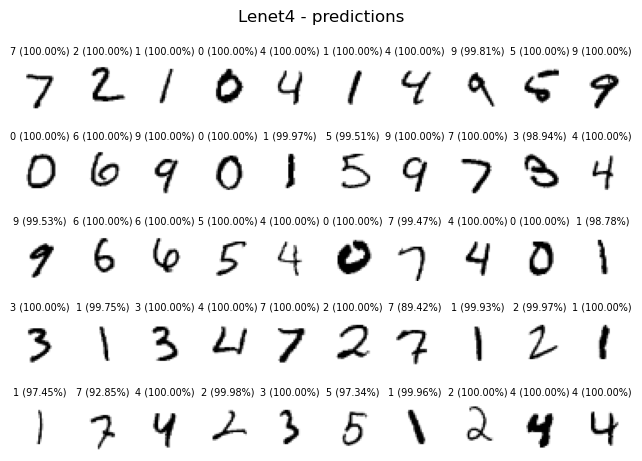

In [37]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
num_subplots = min(len(valid_dataset_two_hd_layer), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    
    # Get the image and convert it back to a PIL Image
    img, _ = valid_dataset_two_hd_layer[index]
    img_pil = transforms.ToPILImage()(img)

    # Preprocess the PIL Image using the same transformer used during training
    img = image_transformer_two_hd_layer(img_pil).unsqueeze(0).to(dev)

    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    # The rest of the visualization loop remains unchanged
    with torch.no_grad():
        model.eval()
        probs = model(img)
    label = valid_dataset_two_hd_layer[index][1]
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100
    title = f'{label} ({probability:.2f}%)'
    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Lenet4 - predictions')
plt.show()

In [38]:
# Instantiate your model with the appropriate num_classes
num_classes = 10
model = LeNet4(num_classes)

# Move the model to the GPU
model = model.to(dev)

# Provide dummy input
dummy_input = torch.randn(1, 1, 32, 32).to(dev)

# Create the graph
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Display the graph directly in the Jupyter Notebook
dot.format = 'png'
dot.render('lenet4_graph', directory='./', view=False)
dot.view()

'lenet4_graph.png'

# Lenet-5

In [39]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),   # Use AdaptiveAvgPool2d to get (4, 4) spatial size
            nn.Flatten(),                   # Flatten the tensor for fully connected layers
            nn.Linear(16 * 4 * 4, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        logits = self.classifier(features)
        return logits

In [40]:
torch.manual_seed(rand_seed)
model = LeNet5().to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

Opening in existing browser session.
00:23:26 --- Epoch: 0	Train loss: 0.2740	Valid loss: 0.0871	Train accuracy: 91.70	Valid accuracy: 97.36
00:23:37 --- Epoch: 1	Train loss: 0.0813	Valid loss: 0.0593	Train accuracy: 97.44	Valid accuracy: 98.14
00:23:48 --- Epoch: 2	Train loss: 0.0581	Valid loss: 0.0450	Train accuracy: 98.14	Valid accuracy: 98.54
00:24:00 --- Epoch: 3	Train loss: 0.0476	Valid loss: 0.0462	Train accuracy: 98.48	Valid accuracy: 98.62
00:24:12 --- Epoch: 4	Train loss: 0.0407	Valid loss: 0.0443	Train accuracy: 98.71	Valid accuracy: 98.55
00:24:24 --- Epoch: 5	Train loss: 0.0354	Valid loss: 0.0495	Train accuracy: 98.88	Valid accuracy: 98.37
00:24:35 --- Epoch: 6	Train loss: 0.0301	Valid loss: 0.0323	Train accuracy: 99.03	Valid accuracy: 98.94
00:24:47 --- Epoch: 7	Train loss: 0.0269	Valid loss: 0.0412	Train accuracy: 99.13	Valid accuracy: 98.61
00:24:58 --- Epoch: 8	Train loss: 0.0232	Valid loss: 0.0353	Train accuracy: 99.23	Valid accuracy: 98.94
00:25:10 --- Epoch: 9	Train

/tmp/ipykernel_29155/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_29155/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


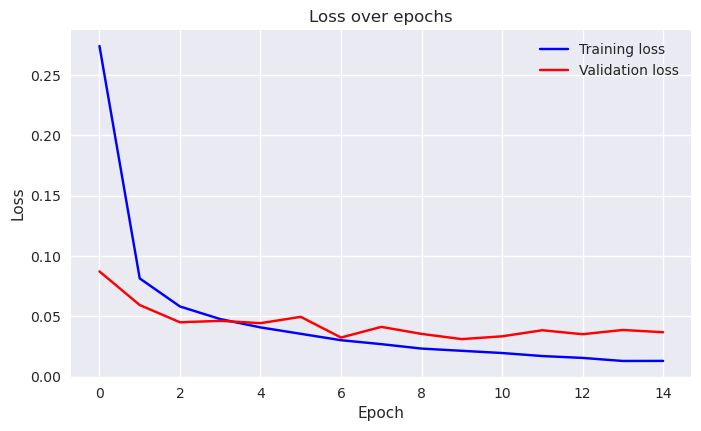

In [41]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader_lenet4up, valid_dloader_lenet4up, epochs, dev)

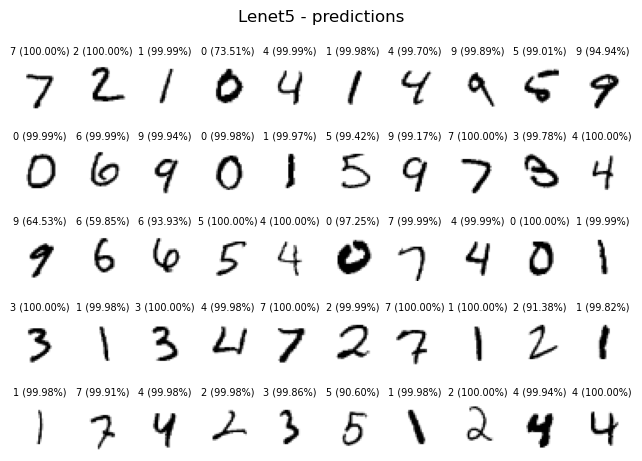

In [42]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
num_subplots = min(len(valid_dataset_two_hd_layer), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    
    # Get the image and convert it back to a PIL Image
    img, _ = valid_dataset_two_hd_layer[index]
    img_pil = transforms.ToPILImage()(img)

    # Preprocess the PIL Image using the same transformer used during training
    img = image_transformer_two_hd_layer(img_pil).unsqueeze(0).to(dev)

    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    # The rest of the visualization loop remains unchanged
    with torch.no_grad():
        model.eval()
        probs = model(img)
    label = valid_dataset_two_hd_layer[index][1]
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100
    title = f'{label} ({probability:.2f}%)'
    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Lenet5 - predictions')
plt.show()

In [43]:
# Instantiate your model
model = LeNet5()

# Move the model to the GPU
model = model.to(dev)

# Provide dummy input
dummy_input = torch.randn(1, 1, 32, 32).to(dev)

# Create the graph and save it as an image
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('lenet5_graph', directory='./', view=False)

'lenet5_graph.png'